In [1]:
import time
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt


from model import Resnet, EBMDiffusionModel
from diffusion import DiffusionModel
from toys import toy_gmm

In [2]:
# Train Spiral EBM Model
batch_size = 1000
data_dim = 2
num_steps = 15001

EMA = .999

n_steps = 100
net_params = {"n_layers": 4,
              "h_dim": 128,
              "emb_dim": 32}

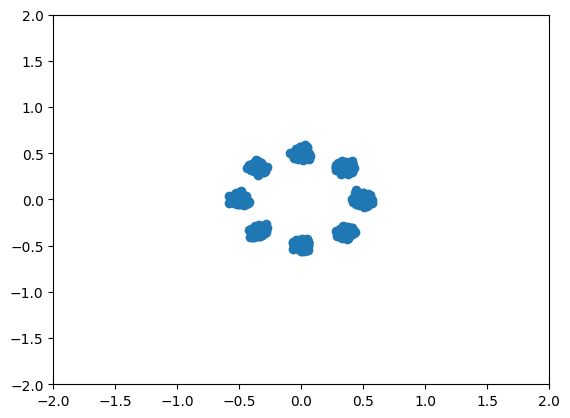

In [3]:
xr = [-.75, .75]
yr = [-.75, .75]

# load data
dataset_energy, dataset_sample = toy_gmm(std=.03)
x = dataset_sample(batch_size)

plot_samples(x)
plt.show()
x = x.reshape(x.shape[0], -1)

In [5]:
net = Resnet(n_steps=n_steps, n_layers=4, x_dim=data_dim, h_dim=128, emb_dim=32)

ebm_net = EBMDiffusionModel(net)

ddpm = DiffusionModel(data_dim, n_steps, ebm_net, device=torch.device("cpu"), var_type="beta_forward")

In [6]:
def logp_unnorm(net, ddpm, x, t):
    scale_e = ddpm.energy_scale(-2 - t)
    t = torch.ones((x.shape[0],)).int() * t
    return -net.neg_logp_unnorm(x, t) * scale_e

In [7]:
ddpm

DiffusionModel(
  (net): EBMDiffusionModel(
    (net): Resnet(
      (layer_x): Linear(in_features=2, out_features=128, bias=True)
      (layers): ModuleList(
        (0-3): 4 x Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): Linear(in_features=32, out_features=256, bias=True)
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): Linear(in_features=256, out_features=128, bias=True)
        )
      )
      (last_layer): Linear(in_features=128, out_features=2, bias=True)
      (time_emb): Embedding(100, 32)
    )
  )
)

In [ ]:
def plot_samples(x):
    plt.scatter(x[:, 0], x[:, 1])
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)

def dist_show_2d(fn, xr, yr):
    nticks = 100
    x, y = np.meshgrid(np.linspace(xr[0], xr[1], nticks), np.linspace(yr[0], yr[1], nticks))
    x = torch.Tensor(x)
    y = torch.Tensor(y)
    coord = torch.stack([x, y], axis=-1).reshape((-1, 2))
    heatmap = fn(coord).reshape((nticks, nticks)).detach().numpy()
    plt.imshow(heatmap)

In [8]:
losses = []
test_logpx = []
itr = 0

ddpm.train()
optimizer = torch.optim.Adam(ddpm.parameters(), lr=1e-3)


for itr in range(num_steps):
    ddpm.train()
    
    x = torch.from_numpy(dataset_sample(batch_size)).float()

    x = x.reshape(x.shape[0], -1)
    start_time = time.time()

    loss = ddpm.loss(x)
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    duration_update = time.time() - start_time

    if itr % 100 == 0:
        print(itr, loss, "time:", duration_update)
        losses.append(loss)
        
    if itr % 1000 == 0:
        ddpm.eval()
        x_samp = ddpm.sample(batch_size)

        plot_samples(x_samp.detach().numpy())
        plt.show()


        for t in range(10):
            dist_show_2d(lambda x: logp_unnorm(ebm_net, ddpm, x, 10 * t), xr=xr, yr=yr)
            plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!